In [ ]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shutil

import random
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset

**Name**: PlantVillage Dataset

**Dataset Links**:
   - Kaggle - https://www.kaggle.com/datasets/emmarex/plantdisease
   - PapersWithCode - https://paperswithcode.com/dataset/plantvillage
   - Mendeley - https://data.mendeley.com/datasets/tywbtsjrjv/1*

**Paper**: Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network - https://doi.org/10.1016/j.compeleceng.2019.04.011

\* Our choise.

In [ ]:
# loading dataset
!wget -O plantvillage.zip https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
!unzip plantvillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/i

In [ ]:
# set dataset directory
data_dir = 'Plant_leave_diseases_dataset_without_augmentation'
# directory for dataset splits
new_data_dir = 'PlantVillage'
os.makedirs(new_data_dir, exist_ok=True)

In [ ]:
# set random seed
seed = 49
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Classes

The following 39 classes are availaible in the dataset. The images for each class are in their respectively named class directory.

In [ ]:
!tree -d Plant_leave_diseases_dataset_without_augmentation

Plant_leave_diseases_dataset_without_augmentation
├── Apple___Apple_scab
├── Apple___Black_rot
├── Apple___Cedar_apple_rust
├── Apple___healthy
├── Background_without_leaves
├── Blueberry___healthy
├── Cherry___healthy
├── Cherry___Powdery_mildew
├── Corn___Cercospora_leaf_spot Gray_leaf_spot
├── Corn___Common_rust
├── Corn___healthy
├── Corn___Northern_Leaf_Blight
├── Grape___Black_rot
├── Grape___Esca_(Black_Measles)
├── Grape___healthy
├── Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
├── Orange___Haunglongbing_(Citrus_greening)
├── Peach___Bacterial_spot
├── Peach___healthy
├── Pepper,_bell___Bacterial_spot
├── Pepper,_bell___healthy
├── Potato___Early_blight
├── Potato___healthy
├── Potato___Late_blight
├── Raspberry___healthy
├── Soybean___healthy
├── Squash___Powdery_mildew
├── Strawberry___healthy
├── Strawberry___Leaf_scorch
├── Tomato___Bacterial_spot
├── Tomato___Early_blight
├── Tomato___healthy
├── Tomato___Late_blight
├── Tomato___Leaf_Mold
├── Tomato___Septoria_leaf_spot
├─

## Splitting Dataset

In [ ]:
# get list of all image paths
image_paths = []
class_names = sorted(os.listdir(data_dir))
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)

print(f"Total images: {len(image_paths)}")

# split into train, temp (val + test)
train_paths, temp_paths = train_test_split(
    image_paths,
    test_size=0.3,
    stratify=[os.path.basename(os.path.dirname(p)) for p in image_paths],
    random_state=seed
)

# split temp into val and test
val_paths, test_paths = train_test_split(
    temp_paths,
    test_size=0.5,
    stratify=[os.path.basename(os.path.dirname(p)) for p in temp_paths],
    random_state=seed
)

# export indices for reproducibility
np.save('train_indices.npy', train_paths)
np.save('val_indices.npy', val_paths)
np.save('test_indices.npy', test_paths)

print("Train dataset size:", len(train_paths))
print("Validation dataset size:", len(val_paths))
print("Test dataset size:", len(test_paths))

Total images: 55448
Train dataset size: 38813
Validation dataset size: 8317
Test dataset size: 8318


In [ ]:
def copy_images(image_list, subset_name, source_dir, destination_dir):
    for image_path in image_list:
        class_name = os.path.basename(os.path.dirname(image_path))
        dest_dir = os.path.join(destination_dir, subset_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)

        dest_path = os.path.join(dest_dir, os.path.basename(image_path))
        shutil.copy2(image_path, dest_path)

# copy images to new directory
copy_images(train_paths, 'train', data_dir, new_data_dir)
copy_images(val_paths, 'val', data_dir, new_data_dir)
copy_images(test_paths, 'test', data_dir, new_data_dir)

In [ ]:
# load datasets
train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(new_data_dir, 'train'),
    shuffle=True,
    seed=seed
)
val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(new_data_dir, 'val'),
    shuffle=False
)
test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(new_data_dir, 'test'),
    shuffle=False
)

Found 38813 files belonging to 39 classes.
Found 8317 files belonging to 39 classes.
Found 8318 files belonging to 39 classes.


### Verifying Splits

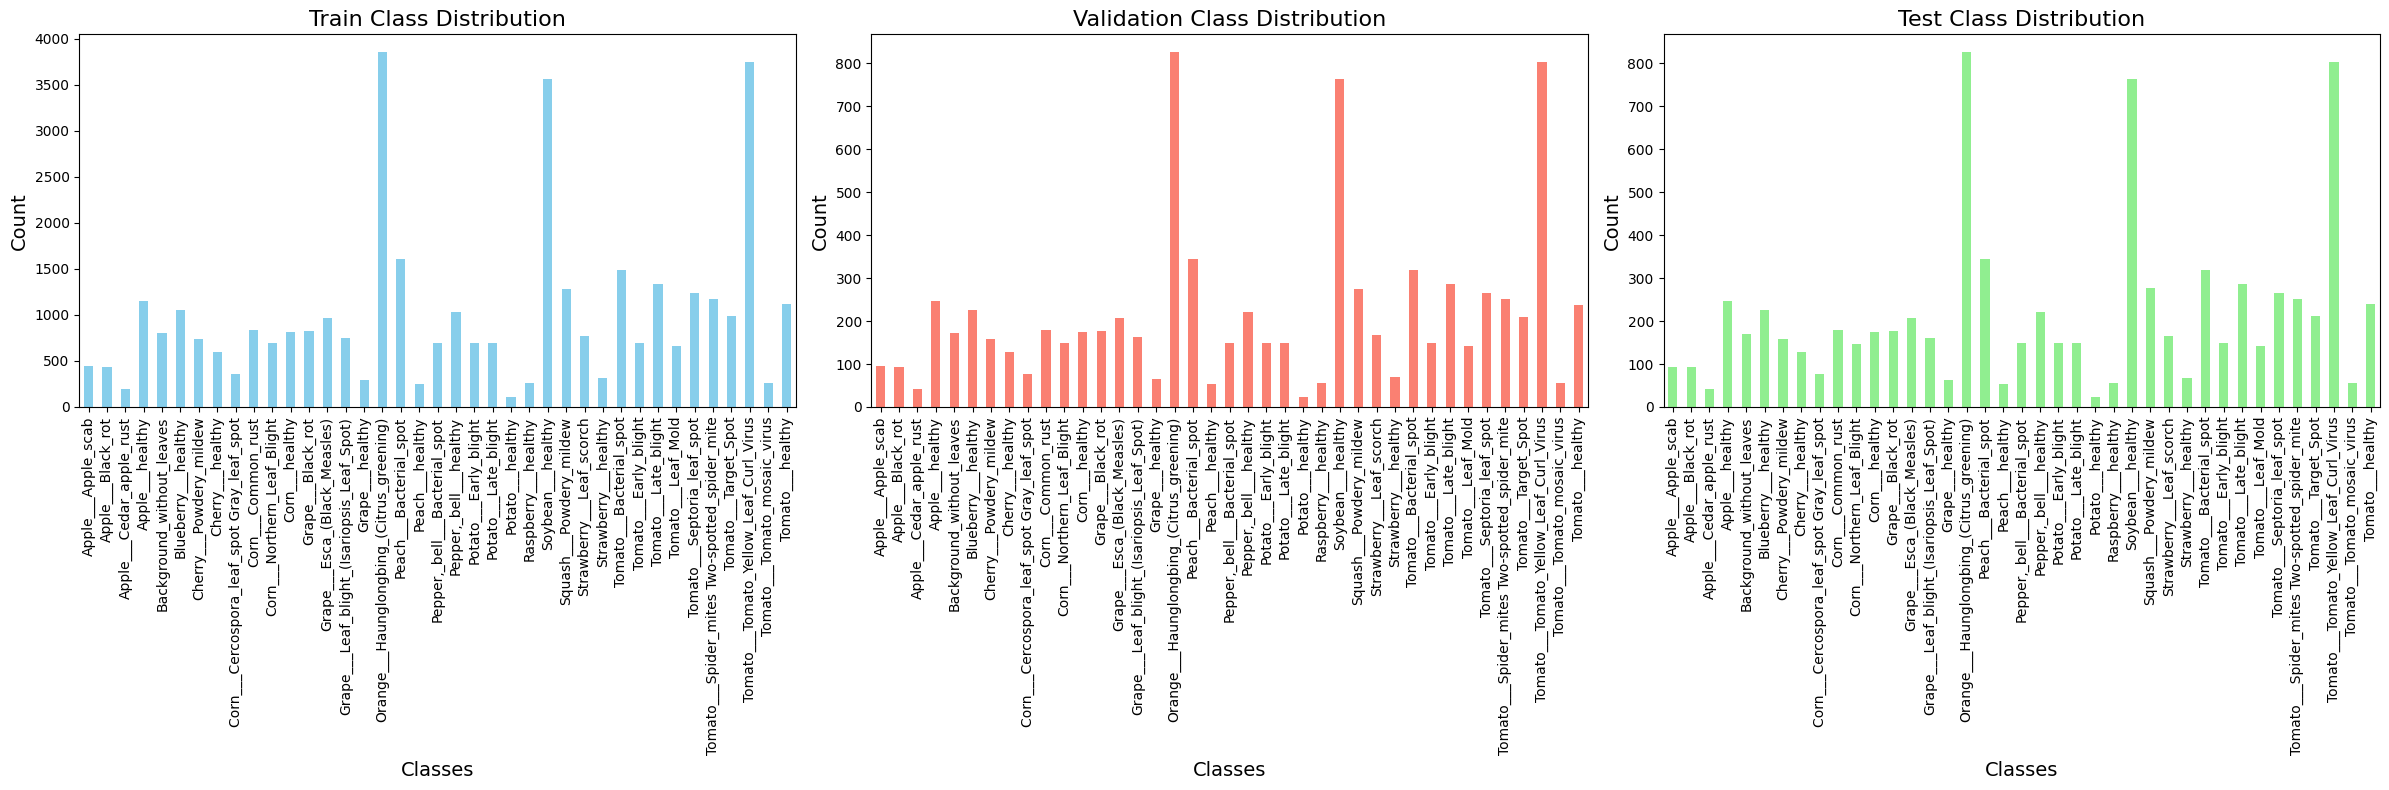

In [ ]:
def get_class_counts(split_dir):
    split_path = os.path.join(new_data_dir, split_dir)
    if not os.path.exists(split_path):
        print(f"Directory {split_path} does not exist.")
        return pd.Series()

    classes = [
        d for d in os.listdir(split_path)
        if os.path.isdir(os.path.join(split_path, d))
    ]

    class_counts = {}
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        count = len([
            f for f in os.listdir(cls_path)
            if os.path.isfile(os.path.join(cls_path, f))
        ])
        class_counts[cls] = count

    return pd.Series(class_counts).sort_index()

train_counts = get_class_counts('train')
val_counts = get_class_counts('val')
test_counts = get_class_counts('test')

# plotting
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

train_counts.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Train Class Distribution', fontsize=16)
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)

val_counts.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_title('Validation Class Distribution', fontsize=16)
axes[1].set_xlabel('Classes', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)

test_counts.plot(kind='bar', color='lightgreen', ax=axes[2])
axes[2].set_title('Test Class Distribution', fontsize=16)
axes[2].set_xlabel('Classes', fontsize=14)
axes[2].set_ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()

## Class Weights For Training Set

In [ ]:
class_labels = train_counts.index.tolist()
class_counts = train_counts.values

# calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels),
    y=np.concatenate([[cls] * count for cls, count in zip(class_labels, class_counts)])
)

class_weights = dict(zip(range(len(class_names)), class_weights))

# export class weights
np.save('class_weights.npy', class_weights)
print("Class weights:", class_weights)

Class weights: {0: 2.256700970986685, 1: 2.2878278809313293, 2: 5.156503254948851, 3: 0.8638933404558404, 4: 1.2440064102564103, 5: 0.9469125863036424, 6: 1.3521808807134894, 7: 1.6642226224166023, 8: 2.772159131490608, 9: 1.1932915206296502, 10: 1.4423262727610553, 11: 1.224114548837796, 12: 1.2048488234928914, 13: 1.0281044712862895, 14: 1.3216535567133176, 15: 3.3621794871794872, 16: 0.2581595663307726, 17: 0.6189086618191095, 18: 3.949226699226699, 19: 1.4257953126147969, 20: 0.9615508485073703, 21: 1.4217216117216118, 22: 1.4217216117216118, 23: 9.388727624576681, 24: 3.8277120315581854, 25: 0.279316623128018, 26: 0.7750818755491653, 27: 1.282480835315887, 28: 3.1197652921790855, 29: 0.668371476296258, 30: 1.4217216117216118, 31: 0.7449140181176109, 32: 1.4943019943019944, 33: 0.8025847808105873, 34: 0.848427219271209, 35: 1.0124162036674753, 36: 0.2653880341880342, 37: 3.813046468218882, 38: 0.8933618745108871}


## Visualizing Training Samples

Found 38813 images belonging to 39 classes.


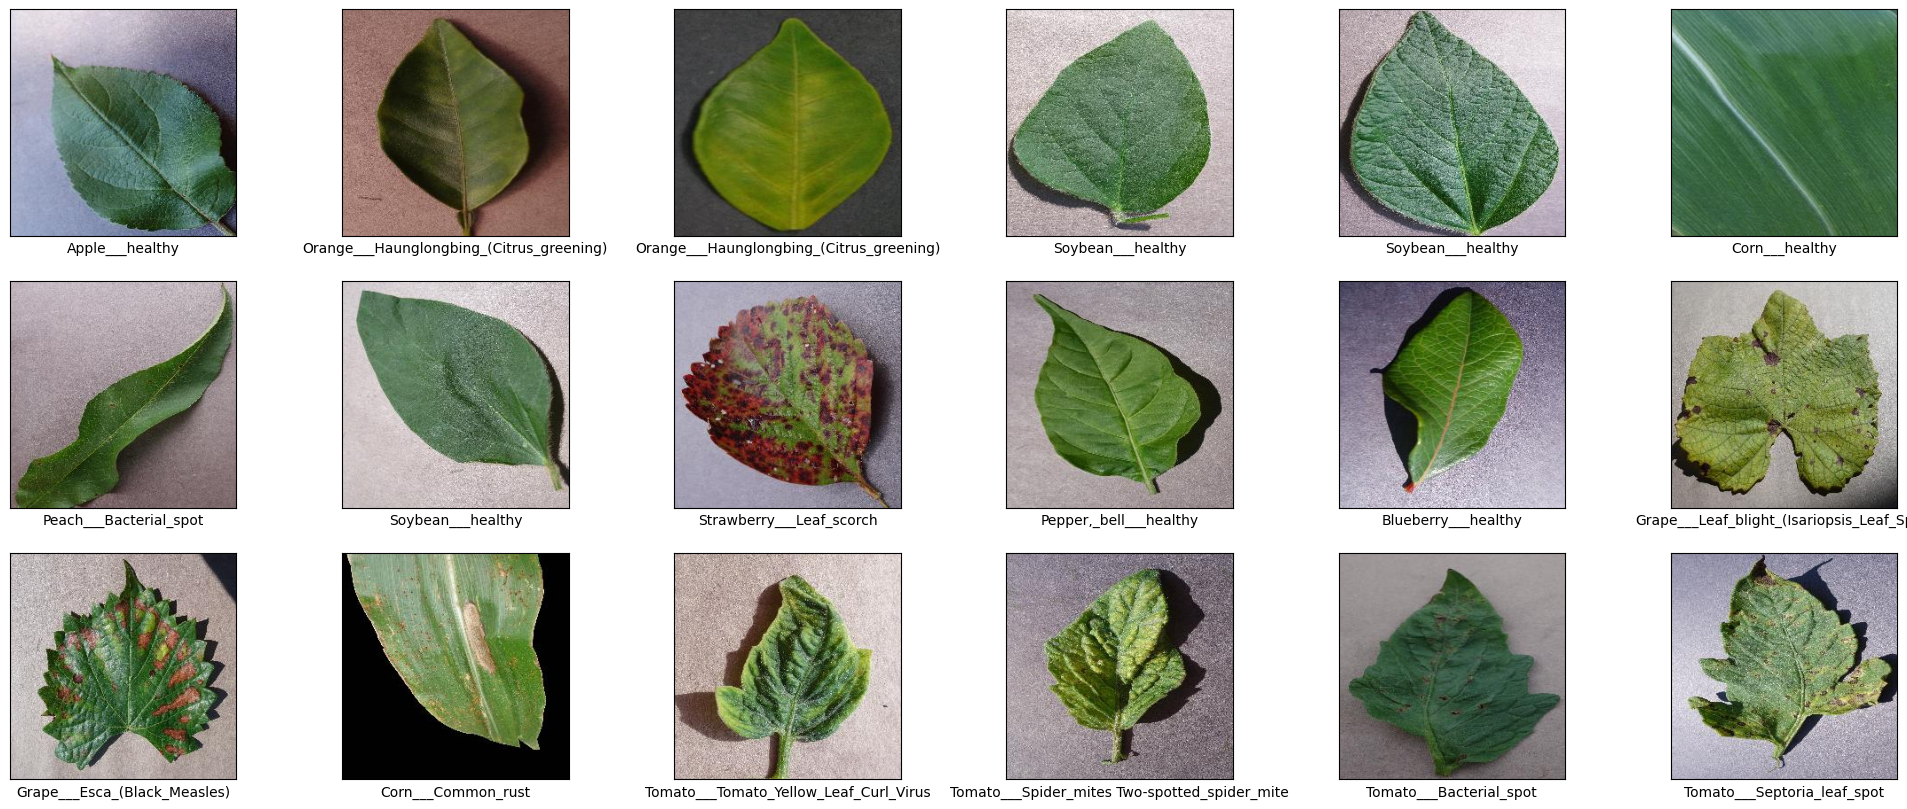

In [ ]:
# create data generator
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
    os.path.join(new_data_dir, 'train'),
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=seed
)

images, labels = next(generator)

num_samples = 18

random_indices = np.random.choice(32, num_samples, replace=False)
sample_images = images[random_indices]
sample_labels = labels[random_indices]

class_names = list(generator.class_indices.keys())

plt.figure(figsize=(25,10))
for i in range(num_samples):
    plt.subplot(3, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i])
    label_index = np.argmax(sample_labels[i])
    plt.xlabel(class_names[label_index])
plt.show()